# First get saccade times across the session

In [33]:
import random
from scipy.spatial import distance
import scipy.stats as sci
from eyeutil import *
from beh_utils import * 
import sys
import os.path
import pprint
import matplotlib.pyplot as plt
import scipy.io #MT

%matplotlib inline

target_sessions=[1]

#freiburg laptop resolution is 1920x1080
#WHAT IS DUNGEON RM COMP RESOLUTION?
resX=3860
resY=2140

data_dir = "/home1/melina.tsitsiklis/eyetracking/behavioral/" #"behavioral/"
subj_index=-1
subjects_id = ["Uma_regth1"] #["Melina"]

# subjects_id = ["CUBF40"]
print("total subject count: " + str(len(subjects_id)))
# subjects_id = ["300518"]
subj_saccade_total=np.zeros([len(subjects_id),1],dtype=int)
subj_saccade_distribution = np.zeros([40,len(subjects_id)],dtype=int)


#cross-population tallies
phase_saccade_count = np.zeros([12,1],dtype=int)
pop_sacc_start_times=np.zeros([0,1],dtype=int)
pop_sacc_end_times=np.zeros([0,1],dtype=int)

for subjects in subjects_id:
    total_sess=get_total_sess_count(subjects)
    print("total sessions: " + str(total_sess-1) + " for " + str(subjects))
    subj_samples=0
    subj_sacc_count=0
    #update the subj_index
    subj_index+=1
    #reset subj_saccade_total
    
    for i in target_sessions:
#     for i in range(1,2):
        zeroes_count=0
        velocity=np.zeros([2000000,1],dtype=float)
        posX = np.zeros([2000000,1],dtype=float)
        posY = np.zeros([2000000,1],dtype=float)
        eyetracker_timestamp = np.zeros([2000000,1],dtype=int)
        
        startTrialTime = np.zeros([40,1],dtype=int)
        endTrialTime = np.zeros([40,1],dtype=int)
        
        cortanaAvg = np.zeros([40,1],dtype=float)
        
        sess_id=i
        unique_samples=0
        prev_timestamp = 0
        times=np.zeros([2000000,1],dtype=int)
        count_eyetracker_entries = 0
        
        timediff=-1
        trialindex=0
        #logfile=data_dir+"sub"+subjects+"/session_"+str(i)+"/Beh/sub"+subjects+"Log.txt"
        logfile=data_dir+subjects+"Log.txt"
        print('logfile is',logfile)
        if os.path.isfile(logfile):
                    inFile = open(logfile)
                    for s in inFile.readlines():
                        s = s.replace('\r','8')
                        tokens = s[:-1].split('\t')
                        if len(tokens)>1:
                            phase=-999
                            latency = 0
                            if tokens[2]=="Trial Event":
                                phase_name=tokens[3][0:len(tokens[3])-1]
                                #remove _started or _ended markers
                                trimmed_phase_name=phase_name.replace('_ENDED','')
                                trimmed_phase_name=phase_name.replace('_STARTED','')
                                
                                if phase_name=="TRIAL_NAVIGATION_STARTED":
                                    startTrialTime[trialindex,0]=float(tokens[0])
                                if phase_name=="RECALL_PHASE_ENDED":
                                    itemindex=0
                                    endTrialTime[trialindex,0]=float(tokens[0])
                                    trialindex+=1
                                
                                    
#                             if tokens[2]=="EYETRACKER_LATENCY": #out tobii eyetracker doesnt have latency probs take out
#                                 latency = int(tokens[3][0:len(tokens[3])-1])
#                                 if latency > 100000:
#                                     latency = 0
#                                 else:
#                                     latency = latency / 1000
# #                                     print "latency is: " + str(latency)

                            if tokens[2]=="EYETRACKER_DISPLAY_POINT":
                                count_eyetracker_entries += 1
                                if prev_timestamp == int(tokens[5]):
                                    continue
                                else:
                                    posX[unique_samples,0]= float(tokens[3])*resX
                                    posY[unique_samples,0] = float (tokens[4])*resY
                                    eyetracker_timestamp[unique_samples,0] = int(tokens[5])
                                    prev_timestamp = int(tokens[5]) #eyetracker timestamp
                                    timestamp=int(tokens[0]) #game timestamp
                                    times[unique_samples,0]=timestamp #- latency
                                    unique_samples+=1

        #print(sum(diff(eyetracker_timestamp)==0))
        print(count_eyetracker_entries)
        
        for i in range(5,unique_samples-6):
            velocity[i,0]=calculate_vel(posX,posY,i,unique_samples,times)
        
        #filter out saccade samples that cross the threshold velocity
        total=0
        mindistance=100
        current_dist=100
        prev_index=-1
        cleanVel = velocity[velocity != 0] #only want times when eyes moving
        
        print("orig thresh: " + str(np.std(velocity)))
        print("threshold velocity:" + str(np.std(cleanVel)))
        thresh=np.std(cleanVel)
        [sacc_count,start_times_sacc,end_times_sacc] = calculate_saccades(velocity,thresh,unique_samples,times)

        print(start_times_sacc.shape) #wait why are there still some zeros in here??
        print(np.trim_zeros(start_times_sacc).shape) 
        start_times=np.trim_zeros(start_times_sacc)
        end_times=np.trim_zeros(end_times_sacc)
        print(start_times.shape)
  
        print("saccade count: " + str(sacc_count))
        subj_sacc_count+=sacc_count
        
        pop_sacc_start_times=np.concatenate((pop_sacc_start_times,start_times),axis=None)
        pop_sacc_end_times=np.concatenate((pop_sacc_end_times,end_times),axis=None)
    subj_saccade_total[subj_index,0]=subj_sacc_count
    
    

total subject count: 1
total sessions: 0 for Uma_regth1
logfile is /home1/melina.tsitsiklis/eyetracking/behavioral/Uma_regth1Log.txt
32631
orig thresh: 2.7650618131933893
threshold velocity:5.510318977553675
(503, 1)
(458, 1)
(458, 1)
saccade count: 458


In [34]:
print(np.shape(np.unique(eyetracker_timestamp)))
print(np.sum(eyetracker_timestamp>0))

print(unique_samples)

(28233,)
28232
28232


# Next get saccades by behavioral task phase
### get saccade location relative to monitor display
### to do: also get virtual location (task)

In [35]:
phase_name_dict={1:'INSTRUCTION_VIDEO', 2:'HOMEBASE_TRANSPORT', 3:'TRIAL_NAVIGATION',4:'PLAYER_CHEST_ROTATION',
            5:'TOWER_TRANSPORT',6:'DISTRACTOR_GAME',7:'RECALL_PHASE',8:'RECALL_CHOICE',
            9:'FEEDBACK',10:'SCORESCREEN'}

phase_dict={'INSTRUCTION_VIDEO': 1,'HOMEBASE_TRANSPORT': 2,'TRIAL_NAVIGATION': 3, 'PLAYER_CHEST_ROTATION': 4,
            'TOWER_TRANSPORT': 5, 'DISTRACTOR_GAME': 6, 'RECALL_PHASE': 7, 'RECALL_CHOICE': 8,
            'FEEDBACK': 9, 'SCORESCREEN': 10, 'BLOCKSCREEN': 11}

In [36]:
data_dir = "/home1/melina.tsitsiklis/eyetracking/behavioral/" #"behavioral/"
#data_dir = "behavioral/"
subj_index=-1
subjects_id = ["Uma_regth1"] #["Melina"]
               #,"050918","120918"]

#cross-population tallies

display=np.zeros([150000,22],dtype=float)
virtual=np.zeros([150000,22],dtype=float)

phase_saccade_count = np.zeros([11,1],dtype=int)
phase_times = np.zeros([11,2],dtype=int)
ignore_phase={'RECALL_SPECIAL','SHOWING_INSTRUCTIONS','SPHINX_EVENT','TASK_PAUSED'}

currIndex=0
Index=0

v_index=0
trial_began=False
phase_index=0

for subjects in subjects_id:
    total_sess=get_total_sess_count(subjects)
    print("total sessions: " + str(total_sess-1) + " for " + str(subjects))
    subj_samples=0
    subj_sacc_count=0
    prevLength=0
    #update the subj_index
    subj_index+=1
    
    for i in target_sessions:
        starting_ts=0
        ending_ts=0
        sess_id=i
        logfile=data_dir+subjects+"Log.txt"
        #logfile=data_dir+"sub"+subjects+"/session_"+str(i)+"/Beh/sub"+subjects+"Log.txt"
        print(logfile)
        print("starting new trial")
        
        if os.path.isfile(logfile):
                    inFile = open(logfile)
                    for s in inFile.readlines():
                        s = s.replace('\r','8')
                        tokens = s[:-1].split('\t')
                        if len(tokens)>1:
                            phase=-999
                            latency = 0
                            if currIndex<pop_sacc_start_times.shape[0]:
                                if trial_began and int(tokens[0])>=pop_sacc_start_times[currIndex] and int(tokens[0]) <=pop_sacc_end_times[currIndex]:
                                    if tokens[2]=="EYETRACKER_DISPLAY_POINT":
                                        display[Index,(phase_index-1)*2]=float(tokens[3])
                                        display[Index,((phase_index-1)*2)+1]=float(tokens[4])
                                        Index+=1
                                    
#                                     if tokens[2]=="EYETRACKER_VIRTUAL_POINT":
#                                         #print("ADDED VIRTUAL LEFT POINT")
#                                         left_virtual[left_v_index,(phase_index-1)*2]=float(tokens[3])
#                                         left_virtual[left_v_index,((phase_index-1)*2)+1]=float(tokens[5])
#                                         left_v_index+=1
                                    
                                if int(tokens[0]) >= pop_sacc_end_times[currIndex]:
                                    diff=Index-prevLength
                                    prevLength=Index
    #                                 print("updated currindex")
                                    currIndex+=1
                                
                                
                            if tokens[2]=="Trial Event":
                                if tokens[3]=="SHOWING_INSTRUCTIONS":
                                    if not trial_began:
                                        trial_began=True
                                phase_name=tokens[3][0:len(tokens[3])]
#                                 print("og " + str(phase_name))
                                phase_index=0
                                if phase_name not in ignore_phase:
                                    phase_index=return_phase_index(phase_name, phase_dict)
                                    if("STARTED" in phase_name):
#                                         print("starting " +str(phase_name))
                                        phase_times[phase_index-1,0]=int(tokens[0])
                                    elif("ENDED" in phase_name):
#                                         print("ending " + str(phase_name))
                                        phase_times[phase_index-1,1]=int(tokens[0])
# #                                         print("between " + str(phase_times[phase_index-1,0]) + " and " + str(phase_times[phase_index-1,1]))
                                        phase_saccs=pop_sacc_start_times[np.logical_and(pop_sacc_start_times>=phase_times[phase_index-1,0], pop_sacc_start_times <= phase_times[phase_index-1,1])].shape[0]
                                        if phase_saccs > 0:
                                            print("adding " + str(phase_saccs) + " into total count for " + str(phase_name_dict[phase_index]))
                                            phase_saccade_count[phase_index-1,0]+=phase_saccs


total sessions: 0 for Uma_regth1
/home1/melina.tsitsiklis/eyetracking/behavioral/Uma_regth1Log.txt
starting new trial
adding 1 into total count for INSTRUCTION_VIDEO
adding 1 into total count for PLAYER_CHEST_ROTATION
adding 2 into total count for TRIAL_NAVIGATION
adding 8 into total count for TOWER_TRANSPORT
adding 1 into total count for DISTRACTOR_GAME
adding 22 into total count for RECALL_CHOICE
adding 22 into total count for RECALL_PHASE
adding 8 into total count for SCORESCREEN
adding 17 into total count for FEEDBACK
adding 4 into total count for HOMEBASE_TRANSPORT
adding 1 into total count for PLAYER_CHEST_ROTATION
adding 6 into total count for TRIAL_NAVIGATION
adding 7 into total count for DISTRACTOR_GAME
adding 2 into total count for RECALL_CHOICE
adding 8 into total count for RECALL_PHASE
adding 8 into total count for FEEDBACK
adding 7 into total count for TRIAL_NAVIGATION
adding 9 into total count for TOWER_TRANSPORT
adding 1 into total count for DISTRACTOR_GAME
adding 25 int

### plot number of saccades by task phase

[2 4 5 6 7 8]
TRIAL_NAVIGATION
TOWER_TRANSPORT
DISTRACTOR_GAME
RECALL_PHASE
RECALL_CHOICE
FEEDBACK


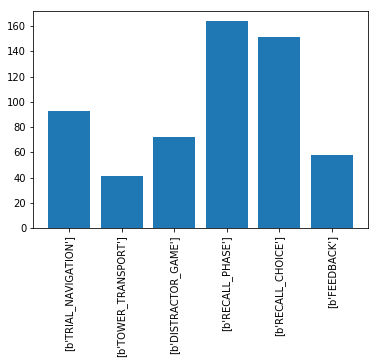

In [37]:
idx=phase_saccade_count[:,0]>40
chosen_idx=np.where(idx)[0]
print(chosen_idx)

fig,ax=plt.subplots()
ax.bar(np.arange(0,len(chosen_idx),1),phase_saccade_count[chosen_idx,0])
ax.xaxis.set_ticks(np.arange(0,len(chosen_idx),1))

label_names=np.empty([len(chosen_idx),1],dtype='S40')
for i in range(0,len(chosen_idx)):
    print(phase_name_dict[chosen_idx[i]+1])
    label_names[i,0]=phase_name_dict[chosen_idx[i]+1]
    
ax.xaxis.set_ticklabels(label_names)
plt.xticks(rotation=90)
plt.show()

In [38]:
print(phase_saccade_count)

[[  1]
 [  5]
 [ 93]
 [  6]
 [ 41]
 [ 72]
 [164]
 [151]
 [ 58]
 [ 14]
 [  0]]


### plot navigation phase display points

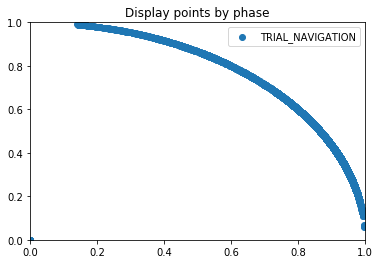

In [41]:
nav_idx = phase_dict['TRIAL_NAVIGATION'] #['RECALL_PHASE'] #
#get index of eye locs during navigation, and get the display position for each one
plt.scatter(np.trim_zeros(display[:,(nav_idx*2)]),np.trim_zeros(display[:,(nav_idx*2)+1]),label=str(phase_name_dict[nav_idx]))

# for target_idx in np.arange(1,11):
#     plt.scatter(np.trim_zeros(display[:,(target_idx*2)]),np.trim_zeros(display[:,(target_idx*2)+1]),label=str(phase_name_dict[target_idx]))


plt.xlim(0,1)
plt.ylim(0,1)
plt.title("Display points by phase")
plt.legend(loc=0)
plt.show()



In [30]:
print(np.shape(np.trim_zeros(display[:,(nav_idx*2)])))

(18355,)


1556044663405
